## Optional
#### use tokenizers to train a tokenizer model

In [1]:
# pip install tokenizers
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer

tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[UNK]"], vocab_size=1000)
tokenizer.train(files=["./data/ted2013-en.txt"], trainer=trainer)

output = tokenizer.encode("this corpus is from tedtalk 2013.")
print(output.tokens)




['this', 'cor', 'p', 'us', 'is', 'from', 't', 'ed', 'talk', '20', '1', '3', '.']


In [2]:
with open("./data/ted2013-en.txt", "r") as f:
    lines = f.readlines()

tokenized_corpus = []
for line in lines:
    output = tokenizer.encode(line)
    tokenized_corpus.append(output.tokens)

print(tokenized_corpus[:3])

[['In', 'the', 'm', 'id', '-', '1', '6', 'th', 'cent', 'ur', 'y', ',', 'It', 'al', 'i', 'ans', 'were', 'cap', 'ti', 'v', 'ated', 'by', 'a', 'ty', 'pe', 'of', 'mal', 'e', 'sing', 'er', 'who', 'se', 'in', 'c', 'red', 'ible', 'r', 'an', 'ge', 'cont', 'ain', 'ed', 'not', 'es', 'pre', 'vi', 'ous', 'ly', 'thought', 'im', 'poss', 'ible', 'for', 'ad', 'ul', 't', 'men', '.'], ['H', 'o', 'we', 'ver', ',', 'this', 'g', 'if', 't', 'came', 'at', 'a', 'high', 'pr', 'ice', '.'], ['T', 'o', 'pre', 'v', 'ent', 'their', 'v', 'o', 'ic', 'es', 'from', 'bre', 'a', 'king', ',', 'these', 'sing', 'ers', 'had', 'been', 'c', 'as', 'tr', 'ated', 'before', 'pu', 'ber', 'ty', ',', 'h', 'al', 'ting', 'the', 'h', 'or', 'mon', 'al', 'pro', 'cess', 'es', 'that', 'would', 'de', 'ep', 'en', 'their', 'v', 'o', 'ic', 'es', '.']]


In [3]:
# get the vocabulary
from collections import Counter
vocab = Counter()
for line in tokenized_corpus:
    vocab.update(line)

print(len(vocab))

999


## Co-occurrence Matrix

In [4]:
# create a numpy array of 1000x1000 to store the co-occurrence matrix
import numpy as np
co_occurrence_matrix = np.ones((1000, 1000))

# iterate through the tokenized corpus and update the co-occurrence matrix, window size = 2
for line in tokenized_corpus:
    for i, token in enumerate(line):
        for j in range(max(i-2, 0), min(i+3, len(line))):
            if i != j:
                co_occurrence_matrix[tokenizer.token_to_id(token), tokenizer.token_to_id(line[j])] += 1

## PMI matrix (optional)

In [5]:
# from the co-occurrence matrix, we can calculate the PMI matrix (optional)
total_occurrences = np.sum(co_occurrence_matrix)
token_occurrences = np.sum(co_occurrence_matrix, axis=1)
pmi_matrix = np.zeros((1000, 1000))
for i in range(1000):
    for j in range(1000):
        pmi_matrix[i, j] = np.log2(co_occurrence_matrix[i, j] * total_occurrences / (token_occurrences[i] * token_occurrences[j]))

## cosine similarity matrix

In [6]:
# cosine similarity matrix can also be calculated by normalizing the co-occurrence matrix
co_occurrence_matrix_normalized = co_occurrence_matrix / np.sqrt(np.sum(co_occurrence_matrix**2, axis=1, keepdims=True))
cosine_similarity_matrix = np.matmul(co_occurrence_matrix_normalized, co_occurrence_matrix_normalized.T)
most_similar_ids = np.argsort(cosine_similarity_matrix, axis=1)[:, -10:]

In [7]:
# find the top 5 most similar words to "thought"
thought_id = tokenizer.token_to_id("thought")
think_id = tokenizer.token_to_id("think")
first_id = tokenizer.token_to_id("first")
next_id = tokenizer.token_to_id("next")
head_id = tokenizer.token_to_id("head")
hand_id = tokenizer.token_to_id("hand")
similarities = most_similar_ids[thought_id][::-1]
most_similar_tokens = [tokenizer.id_to_token(i) for i in similarities]
print(most_similar_tokens)

['thought', 'think', 'mean', 'love', 'did', 'found', 'started', 'when', 'believe', 'was']


## PMI matrix (optional)

In [8]:
pmi_matrix_normalized = pmi_matrix / np.sqrt(np.sum(pmi_matrix**2, axis=1, keepdims=True))
cosine_similarity_PMI = np.matmul(pmi_matrix_normalized, pmi_matrix_normalized.T)
cosine_similarity_PMI = np.argsort(cosine_similarity_PMI, axis=1)[:, -10:]
print([tokenizer.id_to_token(x) for x in cosine_similarity_PMI[thought_id]][::-1])

['thought', 'said', 'talk', 'ask', 'believe', 'think', 'learn', 'mean', 'say', 'course']


In [9]:
print([tokenizer.id_to_token(x) for x in cosine_similarity_PMI[next_id]][::-1])

['next', 'last', 'second', 'ago', 'first', '19', '9', '4', '8', '6']


## Visualizations (optional)

In [10]:
# perform PCA on the PMI matrix
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca_matrix = pca.fit_transform(co_occurrence_matrix_normalized)
pca_matrix.shape

(1000, 3)

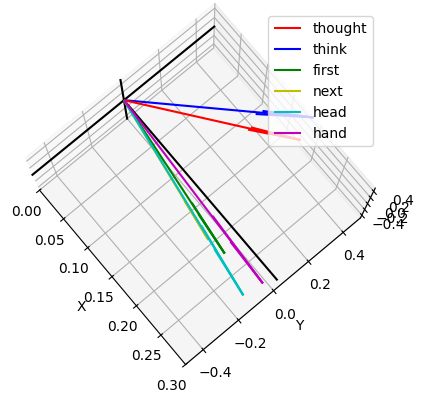

In [11]:
# plot the vector for "thought", "think", "first", "next" in the 3D space and an arrow from origin to the vector
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, pca_matrix[thought_id][0], pca_matrix[thought_id][1], pca_matrix[thought_id][2], color='r', label='thought')
ax.quiver(0, 0, 0, pca_matrix[think_id][0], pca_matrix[think_id][1], pca_matrix[think_id][2], color='b', label='think')
ax.quiver(0, 0, 0, pca_matrix[first_id][0], pca_matrix[first_id][1], pca_matrix[first_id][2], color='g', label='first')
ax.quiver(0, 0, 0, pca_matrix[next_id][0], pca_matrix[next_id][1], pca_matrix[next_id][2], color='y', label='next')
ax.quiver(0, 0, 0, pca_matrix[head_id][0], pca_matrix[head_id][1], pca_matrix[head_id][2], color='c', label='head')
ax.quiver(0, 0, 0, pca_matrix[hand_id][0], pca_matrix[hand_id][1], pca_matrix[hand_id][2], color='m', label='hand')
# set x y z range
ax.set_xlim([0, 0.3])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([-0.5, 0.5])
# set the x y z axis to origin
ax.plot([0, 0], [0, 0], [-0.5, 0.5], color='black')
ax.plot([0, 0], [-0.5, 0.5], [0, 0], color='black')
ax.plot([0, 0.3], [0, 0], [0, 0], color='black')
# label the axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate the plot around the z axis
ax.view_init(azim=-40, elev=80)
plt.legend()
plt.show()

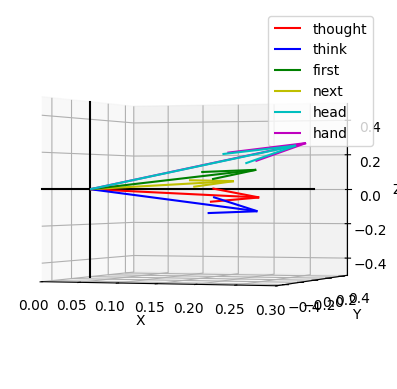

In [12]:
# plot the vector for "thought", "think", "first", "next" in the 3D space and an arrow from origin to the vector
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, pca_matrix[thought_id][0], pca_matrix[thought_id][1], pca_matrix[thought_id][2], color='r', label='thought')
ax.quiver(0, 0, 0, pca_matrix[think_id][0], pca_matrix[think_id][1], pca_matrix[think_id][2], color='b', label='think')
ax.quiver(0, 0, 0, pca_matrix[first_id][0], pca_matrix[first_id][1], pca_matrix[first_id][2], color='g', label='first')
ax.quiver(0, 0, 0, pca_matrix[next_id][0], pca_matrix[next_id][1], pca_matrix[next_id][2], color='y', label='next')
ax.quiver(0, 0, 0, pca_matrix[head_id][0], pca_matrix[head_id][1], pca_matrix[head_id][2], color='c', label='head')
ax.quiver(0, 0, 0, pca_matrix[hand_id][0], pca_matrix[hand_id][1], pca_matrix[hand_id][2], color='m', label='hand')
# set x y z range
ax.set_xlim([0, 0.3])
ax.set_ylim([-0.5, 0.5])
ax.set_zlim([-0.5, 0.5])
# set the x y z axis to origin
ax.plot([0, 0], [0, 0], [-0.5, 0.5], color='black')
ax.plot([0, 0], [-0.5, 0.5], [0, 0], color='black')
ax.plot([0, 0.3], [0, 0], [0, 0], color='black')
# label the axis
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# rotate the plot around the z axis
ax.view_init(azim=-70, elev=0)
plt.legend()
plt.show()

# Using tiktoken
### r50k_base

In [13]:
# setup the tokenizer and test it
import tiktoken
encoding = tiktoken.get_encoding("r50k_base")

inds = encoding.encode("This is a test sentence!")
print(inds)
print([encoding.decode([token]) for token in inds])

[1212, 318, 257, 1332, 6827, 0]
['This', ' is', ' a', ' test', ' sentence', '!']


In [14]:
# word embedding

from collections import Counter
with open("./data/en_tokens.txt", "r") as file:
    text = file.read().split("\n")

# count the tokens
tokens = []
for line in text:
    tokens += line.split(" ")

counter = Counter(tokens)
print(len(counter.most_common()))

25624


In [18]:
# pip install gensim
from gensim.test.utils import datapath
from gensim import utils
import gensim.models
import os
cwd = os.getcwd()
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = datapath(cwd + '/data/en_tokens.txt')
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [19]:
sentences = MyCorpus()
model = gensim.models.Word2Vec(sentences=sentences, workers=7, epochs=7)

In [20]:
model.wv.vectors.shape

(21731, 100)

In [21]:
print(model.wv.most_similar(positive=['thought'], topn=10))

[('knew', 0.6777411699295044), ('realized', 0.6761671304702759), ('think', 0.6174479722976685), ('thinking', 0.6010403633117676), ('said', 0.5815607309341431), ('worried', 0.5774828195571899), ('assumed', 0.5744220614433289), ('wondered', 0.5618284940719604), ('hoped', 0.5591582655906677), ('noticed', 0.5495387315750122)]


## word analogy

In [22]:
import numpy as np

with open("data/glove.6B.50d.txt", 'r') as f:
    vectors = {}
    words = []
    for line in f:
        vals = line.rstrip().split(' ')
        vectors[vals[0]] = list(map(float, vals[1:]))
        words.append(vals[0])


word2id = {w: idx for idx, w in enumerate(words)}
id2word = {idx: w for idx, w in enumerate(words)}

vocab_size = len(words)
vector_dim = 50
W = np.zeros((vocab_size, vector_dim))

for word, v in vectors.items():
    if word == '<unk>':
        continue
    W[word2id[word], :] = v

# normalize each word vector to unit variance
W_norm = np.zeros(W.shape)
d = (np.sum(W ** 2, 1) ** (0.5))
W_norm = (W.T / d).T

W_norm.shape

(400000, 50)

In [23]:
def evaluate_vectors(W, word2id, id2word):
    """Evaluate the trained word vectors on a variety of tasks"""

    filenames = [
        'capital-common-countries.txt', 'capital-world.txt', 'currency.txt',
        'city-in-state.txt', 'family.txt', 'gram1-adjective-to-adverb.txt',
        'gram2-opposite.txt', 'gram3-comparative.txt', 'gram4-superlative.txt',
        'gram5-present-participle.txt', 'gram6-nationality-adjective.txt',
        'gram7-past-tense.txt', 'gram8-plural.txt', 'gram9-plural-verbs.txt',
        ]
    prefix = './question-data'

    # to avoid memory overflow, could be increased/decreased
    # depending on system and vocab size
    split_size = 100

    correct_sem = 0; # count correct semantic questions
    correct_syn = 0; # count correct syntactic questions
    correct_tot = 0 # count correct questions
    count_sem = 0; # count all semantic questions
    count_syn = 0; # count all syntactic questions
    count_tot = 0 # count all questions
    full_count = 0 # count all questions, including those with unknown words

    for i in range(len(filenames)):
        with open('%s/%s' % (prefix, filenames[i]), 'r') as f:
            full_data = [line.rstrip().split(' ') for line in f]
            full_count += len(full_data)
            data = [x for x in full_data if all(word in word2id for word in x)]
        if len(data) == 0:
            print("ERROR: no lines of vocab kept for %s !" % filenames[i])
            print("Example missing line:", full_data[0])
            continue
        indices = np.array([[word2id[word] for word in row] for row in data])
        ind1, ind2, ind3, ind4 = indices.T

        predictions = np.zeros((len(indices),))
        num_iter = int(np.ceil(len(indices) / float(split_size)))
        for j in range(num_iter):
            subset = np.arange(j*split_size, min((j + 1)*split_size, len(ind1)))

            pred_vec = (W[ind2[subset], :] - W[ind1[subset], :]
                +  W[ind3[subset], :])
            #cosine similarity if input W has been normalized
            dist = np.dot(W, pred_vec.T)

            for k in range(len(subset)):
                dist[ind1[subset[k]], k] = -np.inf
                dist[ind2[subset[k]], k] = -np.inf
                dist[ind3[subset[k]], k] = -np.inf

            # predicted word index
            predictions[subset] = np.argmax(dist, 0).flatten()

        val = (ind4 == predictions) # correct predictions
        count_tot = count_tot + len(ind1)
        correct_tot = correct_tot + sum(val)
        if i < 5:
            count_sem = count_sem + len(ind1)
            correct_sem = correct_sem + sum(val)
        else:
            count_syn = count_syn + len(ind1)
            correct_syn = correct_syn + sum(val)

        print("%s:" % filenames[i])
        print('ACCURACY TOP1: %.2f%% (%d/%d)' %
            (np.mean(val) * 100, np.sum(val), len(val)))
        
        with open(f"data/prediction-{filenames[i].split('.')[0]}.txt", "w") as f:
            f.write("%s:\n" % filenames[i])
            for i in range(len(predictions)):
                f.write("Target: " + id2word[ind4[i]] + "\tPrediction:" + id2word[predictions[i]] + "\n")

    print('Questions seen/total: %.2f%% (%d/%d)' %
        (100 * count_tot / float(full_count), count_tot, full_count))
    print('Semantic accuracy: %.2f%%  (%i/%i)' %
        (100 * correct_sem / float(count_sem), correct_sem, count_sem))
    print('Syntactic accuracy: %.2f%%  (%i/%i)' %
        (100 * correct_syn / float(count_syn), correct_syn, count_syn))
    print('Total accuracy: %.2f%%  (%i/%i)' % (100 * correct_tot / float(count_tot), correct_tot, count_tot))

In [24]:
evaluate_vectors(W_norm, word2id, id2word)

capital-common-countries.txt:
ACCURACY TOP1: 79.25% (401/506)
capital-world.txt:
ACCURACY TOP1: 68.48% (3098/4524)
currency.txt:
ACCURACY TOP1: 8.31% (72/866)
city-in-state.txt:
ACCURACY TOP1: 15.32% (378/2467)
family.txt:
ACCURACY TOP1: 68.97% (349/506)
gram1-adjective-to-adverb.txt:
ACCURACY TOP1: 15.22% (151/992)
gram2-opposite.txt:
ACCURACY TOP1: 9.48% (77/812)
gram3-comparative.txt:
ACCURACY TOP1: 51.80% (690/1332)
gram4-superlative.txt:
ACCURACY TOP1: 28.61% (321/1122)
gram5-present-participle.txt:
ACCURACY TOP1: 41.57% (439/1056)
gram6-nationality-adjective.txt:
ACCURACY TOP1: 85.99% (1375/1599)
gram7-past-tense.txt:
ACCURACY TOP1: 37.50% (585/1560)
gram8-plural.txt:
ACCURACY TOP1: 59.91% (798/1332)
gram9-plural-verbs.txt:
ACCURACY TOP1: 34.37% (299/870)
Questions seen/total: 100.00% (19544/19544)
Semantic accuracy: 48.46%  (4298/8869)
Syntactic accuracy: 44.36%  (4735/10675)
Total accuracy: 46.22%  (9033/19544)
